<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#LinearRegressor" data-toc-modified-id="LinearRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Итог</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv("/datasets/taxi.csv",index_col=[0], parse_dates=[0])

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [26]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [27]:
data.sort_index(inplace=True)
data_resample = data.resample('1H').sum()
data_resample.index.is_monotonic

True

In [28]:
data_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные упорядочны

In [29]:
data_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Добавим скользящее среднее на график:

In [30]:
data_rolling_mean = data.copy()

In [31]:
data_rolling_mean['rolling_mean'] = data_rolling_mean.rolling(100).mean()

In [32]:
data_resample_rolling_mean = data_resample.copy()

In [33]:
data_resample_rolling_mean['rolling_mean'] = data_resample_rolling_mean.rolling(100).mean()

Рассмотрим грфик с интревалом по 10 минут

<AxesSubplot:xlabel='datetime'>

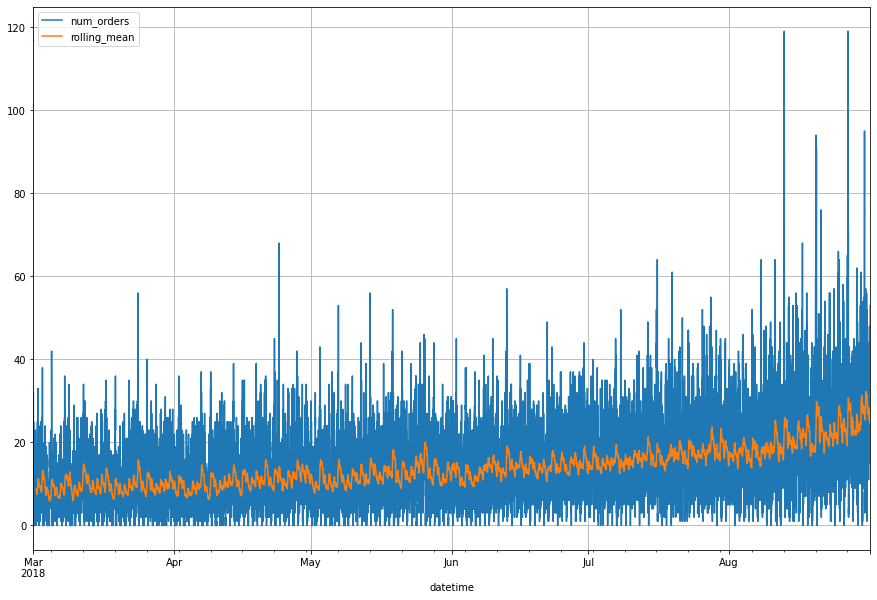

In [34]:
data_rolling_mean.plot(figsize = (15,10), grid = True)

Трудно сказать по графику какие-то выводы. Наблюдаются небольшие пики. Чем ближе к концу графика, тем больше виден спрос на такси.
Скользящее среднее постоянно колеблится, но к концу видно рост

Посмотрим на график с интервалом в 1 час

<AxesSubplot:xlabel='datetime'>

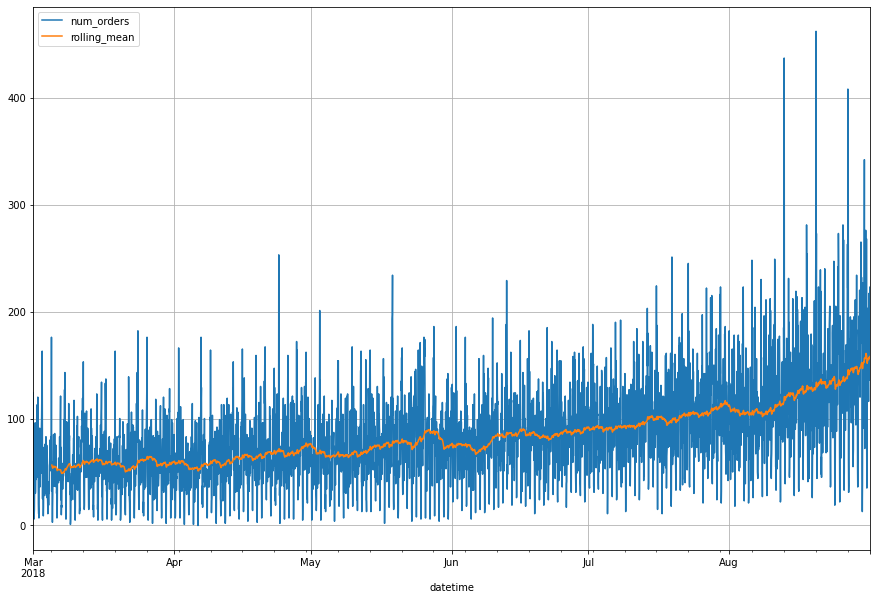

In [35]:
data_resample_rolling_mean.plot(figsize = (15,10), grid = True)

Ситуация аналагична графику с 10 минутами. Но скользящая средняя более гладкая и увеличивается со временем.

Рассмотрим данные более детально.

In [36]:
decomposed_data = seasonal_decompose(data_resample)

(<matplotlib.legend.Legend at 0x7fadff8e90a0>, None)

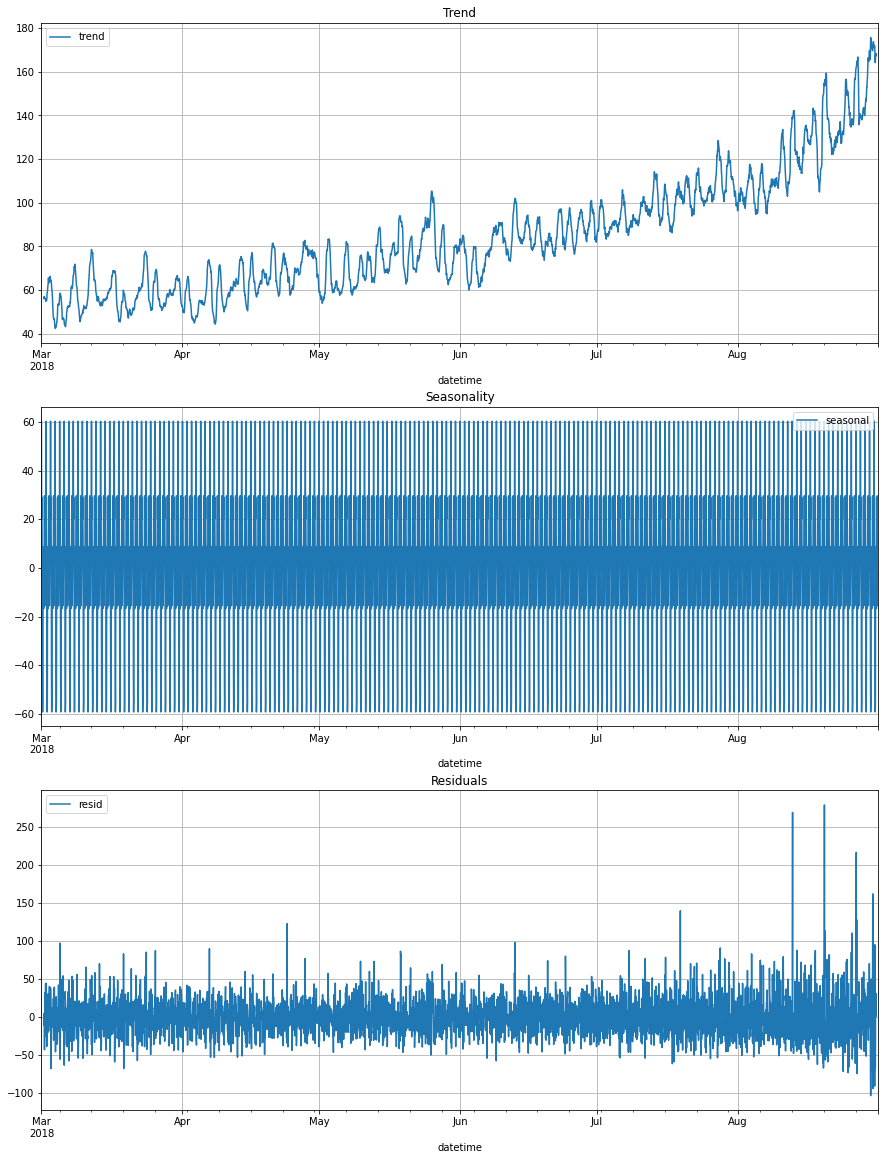

In [37]:
fig , ax = plt.subplots(1,3, figsize=(15,20))

#Trend
plt.subplot(3,1,1)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend(), plt.grid()
#Seasonality
plt.subplot(3,1,2)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.legend(), plt.grid()
#Residuals
plt.subplot(3,1,3)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.legend(), plt.grid()

График тренда показывает возрастающую зависимость к августу.  Это обусловлено ростом отпусков у людей.

График сезонности трудно читается. Рассмотрим его более детально (График по недели и день). 

График остатка декомпозиции особо ничего не показывает

<AxesSubplot:title={'center':'Сезонность заказов в течение 7 дней'}, xlabel='datetime'>

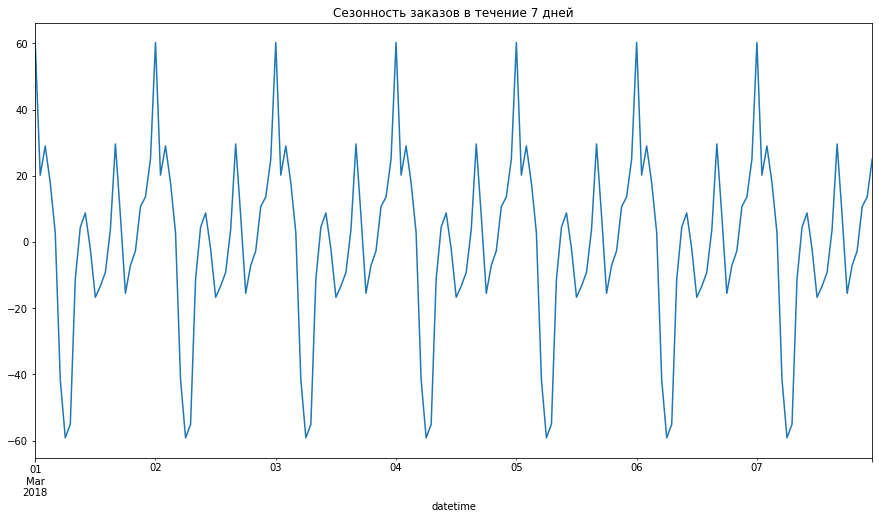

In [38]:
plt.figure(figsize=(15,8))
plt.title("Сезонность заказов в течение 7 дней")
decomposed_data.seasonal['2018-03-01':'2018-03-07'].plot()

<AxesSubplot:title={'center':'Сезонность заказов в течение дня'}, xlabel='datetime'>

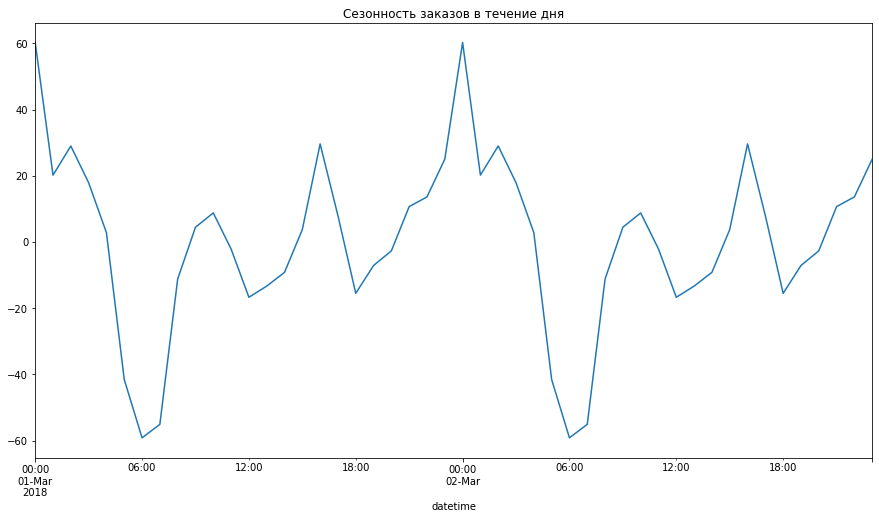

In [39]:
plt.figure(figsize=(15,8))
plt.title("Сезонность заказов в течение дня")
decomposed_data.seasonal['2018-03-01':'2018-03-02'].plot()

Из графиков видно, что наибольший пик приходится на вечер - ночь. Скорей всего это связано с тем, что люди возвращаются с работы/на работу. А ночью такси один из наиболее удобных транспортов, так как общественный транспорт не работает поздней ночью, либо имеет большой интервал.

## Обучение

### Подготовка данных

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    #data['weekday'] = data.index.weekday
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data_resample, 20, 25)

In [42]:
data_resample.head()

,num_orders,month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
train, valid = train_test_split(data_resample, shuffle=False, test_size=0.1)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
train = train.dropna()

In [77]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_valid = valid.drop(columns=['num_orders'])
target_valid = valid['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

In [78]:
data_resample.shape

(4416, 24)

In [79]:
features_train.shape

(3949, 23)

In [80]:
features_valid.shape

(442, 23)

In [81]:
features_test.shape

(442, 23)

### LinearRegressor

In [82]:
model = LinearRegression()
start_time = time.time()
model.fit(features_train, target_train)
time_lr_fit = time.time() - start_time

predict_lr = model.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predict_lr) ** 0.5
time_lr = time.time() -  start_time

print('RMSE LinearRegression:', rmse_lr)

RMSE LinearRegression: 46.49809523676478


### CatBoost

In [83]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=500, random_state=12345)
start_time = time.time()
cat_model.fit(features_train, target_train, verbose=5)
time_cat_fit = time.time() - start_time

predict_cat = cat_model.predict(features_valid)
score_cat = mean_squared_error(target_valid, predict_cat) ** 0.5
time_cat = time.time() -  start_time

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения:",time_cat_fit)
print("Время выполнения:",time_cat)

Learning rate set to 0.089364
0:	learn: 36.9993155	total: 61.5ms	remaining: 30.7s
5:	learn: 31.3895114	total: 85.7ms	remaining: 7.06s
10:	learn: 28.2076908	total: 108ms	remaining: 4.8s
15:	learn: 26.2708545	total: 139ms	remaining: 4.21s
20:	learn: 24.9236769	total: 170ms	remaining: 3.88s
25:	learn: 24.0571156	total: 201ms	remaining: 3.66s
30:	learn: 23.5960324	total: 233ms	remaining: 3.52s
35:	learn: 23.2180922	total: 254ms	remaining: 3.28s
40:	learn: 22.8465446	total: 285ms	remaining: 3.19s
45:	learn: 22.5858241	total: 313ms	remaining: 3.09s
50:	learn: 22.3298773	total: 335ms	remaining: 2.95s
55:	learn: 22.0284583	total: 360ms	remaining: 2.85s
60:	learn: 21.7884130	total: 391ms	remaining: 2.81s
65:	learn: 21.5620601	total: 415ms	remaining: 2.73s
70:	learn: 21.4476147	total: 436ms	remaining: 2.63s
75:	learn: 21.2707656	total: 464ms	remaining: 2.59s
80:	learn: 21.1027519	total: 494ms	remaining: 2.56s
85:	learn: 20.8864998	total: 518ms	remaining: 2.49s
90:	learn: 20.7220444	total: 545ms	

### LightGBM

In [84]:
lgbm_model = LGBMRegressor(num_leaves=50, learning_rate=0.06, n_estimators=500, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train, target_train)
time_lgbm_fit = time.time() - start_time
predict_lgbm = lgbm_model.predict(features_valid)

score_lgbm = mean_squared_error(target_valid, predict_lgbm) ** 0.5
time_lgmb = time.time() -  start_time

print("RMSE LGBMRegressor:", score_lgbm)
print("Время обучения:",time_lgbm_fit)
print("Время выполнения:",time_lgmb)

RMSE LGBMRegressor: 43.94819997764709
Время обучения: 764.1426601409912
Время выполнения: 764.2326381206512


### Итог

In [85]:
data_itog = pd.DataFrame({"Model":["LinearRegression",
                                   "CatBoost",
                                  "LightGBM"],
                          "RMSE":[rmse_lr,score_cat,score_lgbm],
                          "Fit_time":[time_lr_fit,time_cat_fit,time_lgbm_fit],
                          "Predict_time" :[time_lr,time_cat,time_lgmb]
                         })

In [86]:
data_itog.sort_values(by="RMSE")

,Model,RMSE,Fit_time,Predict_time
2,LightGBM,43.948200,764.142660,764.232638
1,CatBoost,44.631734,5.300832,5.303634
0,LinearRegression,46.498095,0.005414,0.077446


Наилучший результат показала LightGBM модель с RMSE равной 43.948200, но долго всех обучалась.

Наихудший результат у LinearRegression (RMSE = 46.498095)

## Тестирование

In [94]:
start_time = time.time()
test_lgbm_predict = lgbm_model.predict(features_test)
test_time_predict = time.time() - start_time
score_lgbm_test = mean_squared_error(target_test, test_lgbm_predict) ** 0.5
test_time_score = time.time() - start_time
print("RMSE LGBMRegressor:", score_lgbm_test)
print("Время обучения:",test_time_predict)
print("Время выполнения:",test_time_score)

RMSE LGBMRegressor: 43.94819997764709
Время обучения: 0.028638839721679688
Время выполнения: 0.029249191284179688


In [95]:
data_itog = pd.DataFrame({"Model":["LinearRegression",
                                   "CatBoost",
                                  "LightGBM",
                                  "Test_LightGBM"],
                          "RMSE":[rmse_lr,score_cat,score_lgbm,score_lgbm_test],
                          "Fit_time":[time_lr_fit,time_cat_fit,time_lgbm_fit,test_time_predict],
                          "Predict_time" :[time_lr,time_cat,time_lgmb,test_time_score]
                         })

In [96]:
data_itog

,Model,RMSE,Fit_time,Predict_time
0,LinearRegression,46.498095,0.005414,0.077446
1,CatBoost,44.631734,5.300832,5.303634
2,LightGBM,43.948200,764.142660,764.232638
3,Test_LightGBM,43.948200,0.028639,0.029249


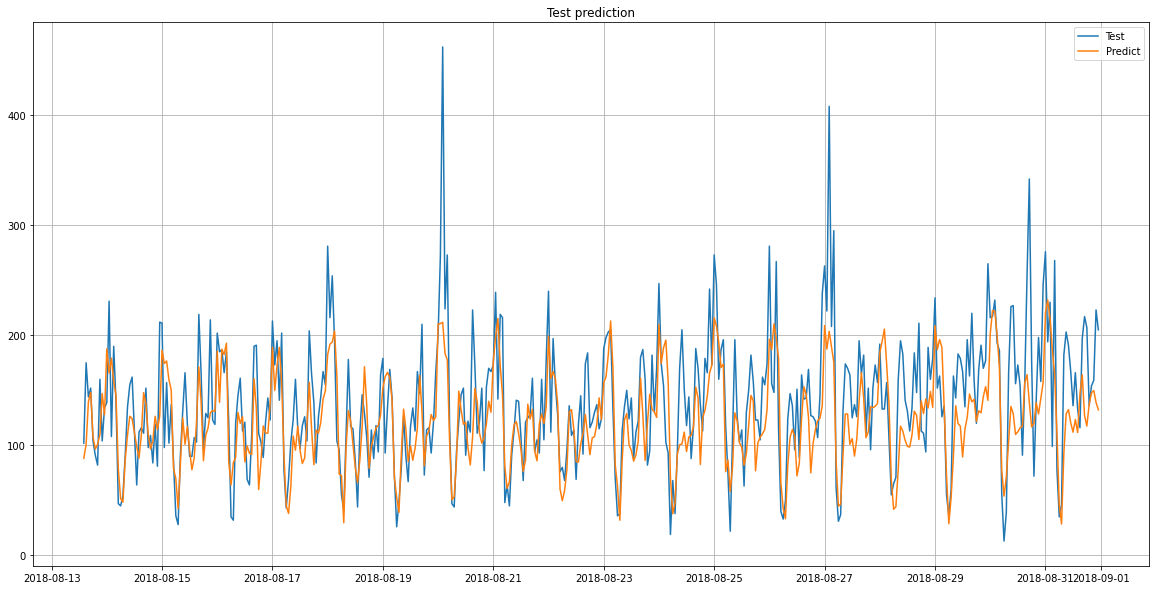

In [97]:
plt.figure(figsize=(20, 10))
#Нанести сначала значения таргета, а потом по его индексу значения предикта
plt.plot(target_test, label='Test')
plt.plot(target_test.index, test_lgbm_predict, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.grid(True)
plt.show()

RMSE получился ниже 48, как и требовалось в условии

## Вывод

1. Были загружены данные. В качестве индекса был выбран столбец с датой и отфильтрован по возрастанию. Данные были ресамплированы по часам;
2. Полученные данные были проанализированы. График тренда показывает возрастающую зависимость к августу.  Это обусловлено ростом отпусков у людей летом. График сезонности показал, что наибольшая активность людей происходит под вечер-ночь.График остатка декомпозиции особо ничего не показывает
3. В таблицу были добавлены новые признаки и обучены на 3х моделей : LightGBM, CatBoost, LinearRegression. Наилучший результат показала LightGBM = 3.2508264609076876, но наиболее долгое время обучения.
4. Модель проверена на тестовой выборке. Результат получился  RMSE = 47.6, что входит в заданный предел проекта (<48).